In [1]:
from DataFolder import DataFolder
from Signal import Signal

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import emd

from bycycle.features import compute_features

INPUT_DIR = "/home/miranjo/common-datasets/LFP_CBD/rem/"

# Filter settings
f_theta = (4, 12)
f_lowpass = 25
n_seconds_filter = .5  # could be changed to 0.1
n_seconds_theta = .75
fs = 2500

#Bycycle threshold settings
threshold_kwargs = {'amp_fraction_threshold': 0.8,
                        'amp_consistency_threshold': 0,
                        'period_consistency_threshold': 0,
                        'monotonicity_threshold': 0,
                        'min_n_cycles': 8}

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)


DataFolder in '/home/miranjo/common-datasets/LFP_CBD/rem/', contains 102 files.


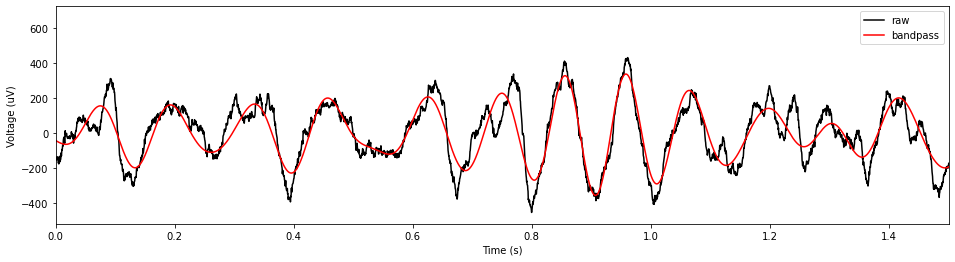

Sampling rate: 2500 Hz
Duration: 122.20 seconds
Max value: 665.82 uV
Min value: -461.92 uV
Mean value: -0.00 uV
Standard Deviation: 159.80 uV
Signal Range: 1127.73 uV
Number of Data Points: 305495


In [2]:
remFolder = DataFolder(INPUT_DIR)
print(remFolder)

sample = remFolder[3]
lfpREM = sample["data"][0]
metadata = sample["metadata"]

sig = Signal(lfpREM, fs)
sig.filter('bandpass', f_theta, n_seconds_theta)
sig.plot(xlim=(0, 1.5))
sig.summary()

# Extracting phasic and tonic segments from a single signal

In [3]:
# Detect phasic and tonic periods
df_byc = compute_features(sig.filtered, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

#Extract Phasic and Tonic states
df_theta_phasic = df_byc[df_byc['is_burst']]
df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]

result_msg = "{} periods in the {} signal: {}"

print(result_msg.format("Phasic", sig.filter_type, len(df_theta_phasic)))
print(result_msg.format("Tonic", sig.filter_type, len(df_theta_tonic)))


df_byc_2 = compute_features(sig.raw_signal, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')
phasic_raw = len( df_byc_2[df_byc_2['is_burst']])
tonic_raw = len(df_byc_2[df_byc_2['is_burst' ] == False])

print(result_msg.format("Phasic", "raw", phasic_raw))
print(result_msg.format("Tonic", "raw", tonic_raw))


Phasic periods in the bandpass signal: 47
Tonic periods in the bandpass signal: 865
Phasic periods in the raw signal: 20
Tonic periods in the raw signal: 893


In [4]:
# Peak to Trough ratio for Bycyle Cycle
p = df_theta_phasic.time_peak
t = df_theta_phasic.time_trough
p2t_phasic = p/(p+t)

# Peak to Trough ratio for Bycyle Cycle
p = df_theta_tonic.time_peak
t = df_theta_tonic.time_trough
p2t_tonic = p/(p+t)

# Ascending to Descending ratio for Bycyle Cycle
A = df_theta_phasic.time_rise
D = df_theta_phasic.time_decay
asc2desc_phasic = A/(A+D)

# Ascending to Descending ratio for Bycyle Cycle
A = df_theta_tonic.time_rise
D = df_theta_tonic.time_decay
asc2desc_tonic = A/(A+D)

In [5]:
def segment(timestamps, signal):

    inds = timestamps.index.to_list()

    # Extract pairs of start and end points
    pairs = []
    start = inds[0]

    for i in range(1, len(inds), 1):
        if (inds[i] != inds[i-1] + 1  ):
            end = inds[i-1]
            if start != end:
                pairs.append((start, end))
            start = inds[i]
    if start != inds[-1]:
        pairs.append((start, inds[-1]))

    # Extract the signal
    samples = []
    for pair in pairs:
        samples.append((timestamps.loc[pair[0]]["sample_last_trough"], timestamps.loc[pair[1]]["sample_next_trough"]))
    
    segmented_signals = []

    for pair in samples:
        start, end = pair
        segment = signal[start:end]
        segmented_signals.append(segment)

    return segmented_signals

def emd_analysis(signal, fs):
    IP, IF, IA = emd.spectra.frequency_transform(signal, fs, 'hilbert', smooth_phase=3)

    C = emd.cycles.Cycles(IP.flatten())
    print("Detected cycles before extraction:")
    print(C)

    # computing the cycle metrics 
    C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
    C.compute_cycle_metric('stop_sample', signal, emd.cycles.cf_end_value)
    C.compute_cycle_metric('peak_sample', signal, emd.cycles.cf_peak_sample)
    C.compute_cycle_metric('desc_sample', signal, emd.cycles.cf_descending_zero_sample)
    C.compute_cycle_metric('trough_sample', signal, emd.cycles.cf_trough_sample)
    C.compute_cycle_metric('duration_samples', signal, len)

    C.compute_cycle_metric('max_amp', IA, np.max)
    C.compute_cycle_metric('mean_if', IF, np.mean)
    C.compute_cycle_metric('max_if', IF, np.max)
    C.compute_cycle_metric('range_if', IF, compute_range)

    C.compute_cycle_metric('asc2desc', signal, asc2desc)
    C.compute_cycle_metric('peak2trough', signal, peak2trough)

    print('\nFinished computing the cycles metrics\n')

    # Extract subset of the cycles 
    amp_thresh = np.percentile(IA, 25)
    lo_freq_duration = fs/5
    hi_freq_duration = fs/12
    conditions = ['is_good==1',
                  f'duration_samples<{lo_freq_duration}',
                  f'duration_samples>{hi_freq_duration}',
                  f'max_amp>{amp_thresh}']

    print("Cycles after extraction:")
    df_emd = C.get_metric_dataframe(conditions=conditions)
    print(f'{len(df_emd)}')
    return df_emd

def plot_hist(feature, bins='auto', ax=None, density=False, **kwargs):

    # Default keyword args
    figsize = kwargs.pop('figsize', (5, 5))
    xlabel = kwargs.pop('xlabel', None)
    xlim = kwargs.pop('xlim', None)
    ylim = kwargs.pop('ylim', None)
    fontsize = kwargs.pop('fontsize', 15)
    alpha = kwargs.pop('alpha', .7)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Axis style
    ax.set_xlabel(xlabel, size=fontsize)

    if density:
        ax.set_ylabel('Cycles density', size=fontsize)
    else:
        ax.set_ylabel('Number of cycles', size=fontsize)

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_xlim(ylim)
        
    ax.hist(feature, bins=bins, alpha=alpha, density=density, **kwargs)

# Phasic signal comparison (Cycle-by-cycle vs EMD)

In [6]:
# Phasic segments
timestamps = df_theta_phasic[["sample_last_trough", 'sample_next_trough']]
phasic = segment(timestamps, sig.filtered)
phasic

[array([-261.32080307, -261.3061409 , -261.14862865, ..., -266.59216283,
        -266.82767259, -266.96198792]),
 array([-238.02369128, -237.90757863, -237.66788851, ..., -218.8244056 ,
        -219.07389816, -219.23895495]),
 array([-245.66030786, -245.58695806, -245.42420651, ..., -258.0211653 ,
        -258.28563174, -258.41869292]),
 array([-250.51924292, -250.42085736, -250.20833721, ..., -324.18216036,
        -324.68330921, -324.99453391]),
 array([-191.5109722 , -191.3622228 , -191.04729905, ..., -235.25041072,
        -235.52425923, -235.68866423])]

In [7]:
df = []
for ph in phasic:
    df_emd = emd_analysis(ph, fs)
    df.append(df_emd)

Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (9 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
7
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (10 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
8
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (12 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
10
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (9 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
7
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (12 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
10


In [8]:
max_amps = pd.concat([df_emd["max_amp"] for df_emd in df], axis=0)
p2t_emd = pd.concat([df_emd["peak2trough"] for df_emd in df], axis=0)
asc2desc_emd = pd.concat([df_emd["asc2desc"] for df_emd in df], axis=0)
durations = pd.concat([df_emd["duration_samples"] for df_emd in df], axis=0)


Text(0.5, 0.92, 'Phasic segments')

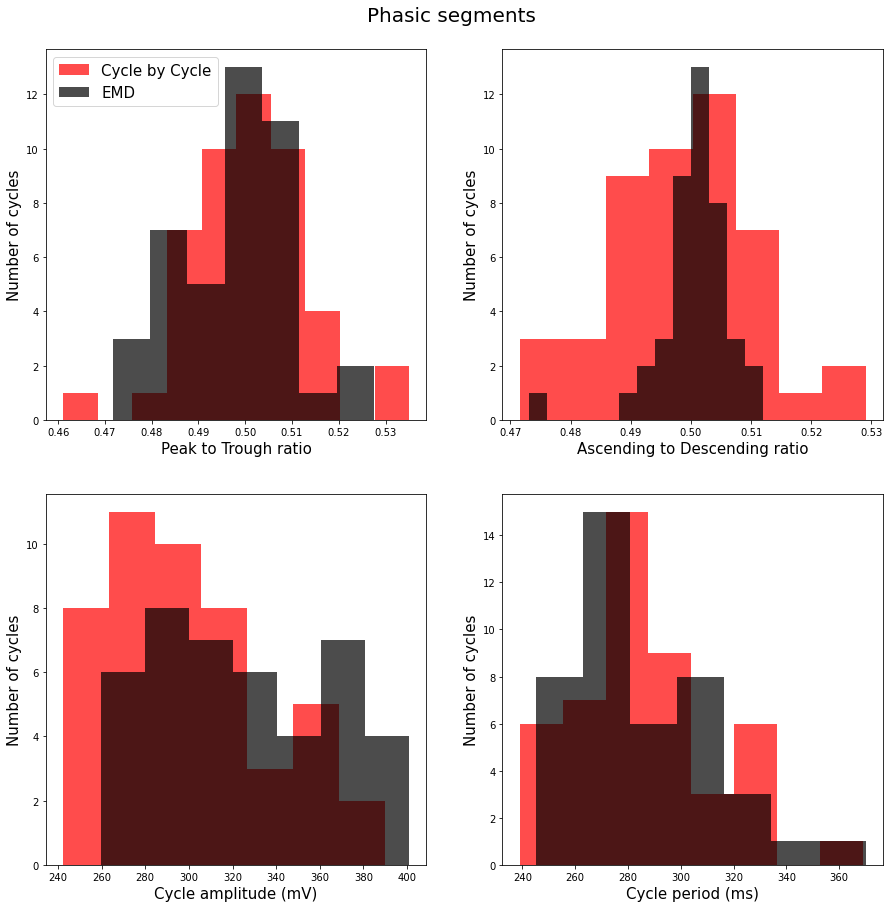

In [9]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Peak to trough ratio
dist1 = p2t_phasic
dist2 = p2t_emd

plot_hist(dist1, ax=axes[0][0], xlabel="Peak to Trough ratio", color='r')
plot_hist(dist2, ax=axes[0][0], xlabel="Peak to Trough ratio", color='k')

axes[0][0].legend(['Cycle by Cycle', 'EMD'], fontsize=15)

# Ascending to descending ratio
dist1 = asc2desc_phasic
dist2 = asc2desc_emd

plot_hist(dist1, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='r')
plot_hist(dist2, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='k')

# Max amplitude
dist1 = df_theta_phasic['volt_peak']
dist2 = max_amps
plot_hist(dist1, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='r')
plot_hist(dist2, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='k')

# Duration of samples
dist1 = df_theta_phasic['time_rise'] + df_theta_phasic['time_decay']
dist2 = durations

plot_hist(dist1, ax=axes[1][1], xlabel="Cycle period (ms)", color='r')
plot_hist(dist2, ax=axes[1][1], xlabel="Cycle period (ms)", color='k')

fig.suptitle("Phasic segments", fontsize=20, y=0.92)

# Tonic signal comparison

In [14]:
timestamps = df_theta_tonic[["sample_last_trough", 'sample_next_trough']]
tonic = segment(timestamps, sig.filtered)

df = []
for ph in tonic:
    df_emd = emd_analysis(ph, fs)
    df.append(df_emd)

Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (325 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
296
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (48 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
45
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (136 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
123
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (265 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
246
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (94 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
81


In [15]:
max_amps = pd.concat([df_emd["max_amp"] for df_emd in df], axis=0)
p2t_emd = pd.concat([df_emd["peak2trough"] for df_emd in df], axis=0)
asc2desc_emd = pd.concat([df_emd["asc2desc"] for df_emd in df], axis=0)
durations = pd.concat([df_emd["duration_samples"] for df_emd in df], axis=0)

Text(0.5, 0.92, 'Tonic segments')

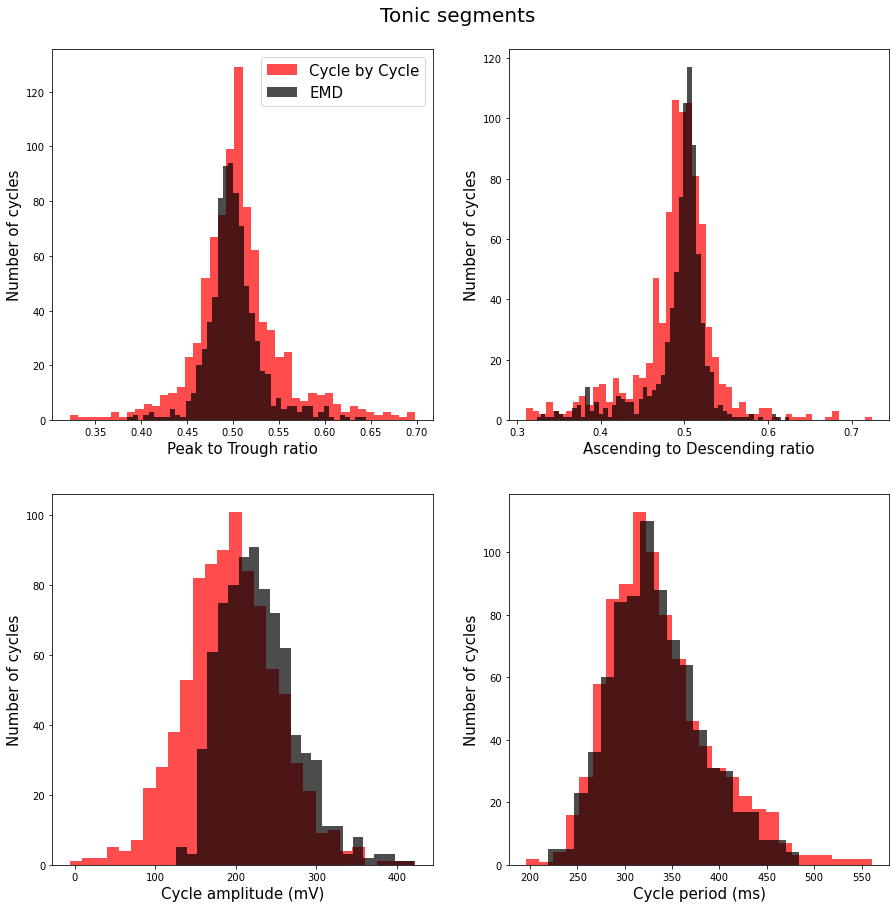

In [ ]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Peak to trough ratio
dist1 = p2t_tonic
dist2 = p2t_emd

plot_hist(dist1, ax=axes[0][0], xlabel="Peak to Trough ratio", color='r')
plot_hist(dist2, ax=axes[0][0], xlabel="Peak to Trough ratio", color='k')

axes[0][0].legend(['Cycle by Cycle', 'EMD'], fontsize=15)

# Ascending to descending ratio
dist1 = asc2desc_tonic
dist2 = asc2desc_emd

plot_hist(dist1, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='r')
plot_hist(dist2, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='k')

# Max amplitude
dist1 = df_theta_tonic['volt_peak']
dist2 = max_amps
plot_hist(dist1, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='r')
plot_hist(dist2, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='k')

# Duration of samples
dist1 = df_theta_tonic['time_rise'] + df_theta_tonic['time_decay']
dist2 = durations

plot_hist(dist1, ax=axes[1][1], xlabel="Cycle period (ms)", color='r')
plot_hist(dist2, ax=axes[1][1], xlabel="Cycle period (ms)", color='k')

fig.suptitle("Tonic segments", fontsize=20, y=0.92)